# DeobfuscNet

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1WnkB7pCg2EyWleeZI0cccyeTW6I0Oe6o)

A project by Alex Blandin - 953274@swansea.ac.uk / a.j.blandin@swansea.ac.uk

Full Repository at https://github.com/AlexBlandin/DeobfuscNet

> Copyright © 2020

In [1]:
!pip install -qqq py-ulid
!pip install -qqq tqdm
!pip install -qqq WeasyPrint
!pip install -qqq fontpreview

In [2]:
###
# CSCM38 CW: DeobfuscNet
# Alex Blandin - 953274@swansea.ac.uk / a.j.blandin@swansea.ac.uk
# Copyright © 2020
###

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Add, BatchNormalization, Dense, Dropout, Flatten, Input, Maximum
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.losses import categorical_crossentropy
from keras.constraints import max_norm
from keras.callbacks import CSVLogger

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from skimage.io import imread,imsave
import matplotlib.pyplot as plt
from ulid import ULID
from tqdm import tqdm
ulid=ULID()

from weasyprint import HTML, CSS
from weasyprint.fonts import FontConfiguration

# Viable Avenue instead of Weasyprint
from fontpreview import FontLogo

import shutil
from time import time
from pathlib import Path
from random import sample
from datetime import datetime
from random import getrandbits, randint
from zipfile import ZipFile, ZIP_DEFLATED
from itertools import combinations_with_replacement

In [3]:
# Prepare results dir
if not Path("./results/").exists():
  Path("./results/").mkdir()

if not Path("./examples/").exists():
  Path("./examples/").mkdir()

# Download dataset etc
if not Path("./Noto-unhinted.zip").exists():
  !wget -q https://github.com/AlexBlandin/DeobfuscNet/raw/main/Noto-unhinted.zip

# Move Fonts
if not Path("/usr/share/fonts/truetype/noto/").exists():
  Path("/usr/share/fonts/truetype/noto/").mkdir()
if Path("./Noto-unhinted.zip").exists():
  if not Path("./fonts/").exists:
    Path("./fonts/").mkdir()
  if Path("./Noto-unhinted.zip").exists():
    with ZipFile("./Noto-unhinted.zip", "r") as z:
      z.extractall("./fonts/")
  for f in Path("./fonts/").rglob("*.*tf"):
    f.rename(Path(f"/usr/share/fonts/truetype/noto/{f.name}"))

if not Path("./tofu.png").exists():
  !wget -q https://github.com/AlexBlandin/DeobfuscNet/raw/main/tofu.png
  !wget -q https://github.com/AlexBlandin/DeobfuscNet/raw/main/tofus.png

# Offline Datasets
if not Path("./dataset.zip").exists():
  !wget -q https://github.com/AlexBlandin/DeobfuscNet/raw/main/dataset.zip
  with ZipFile("./dataset.zip","r") as z: z.extractall("./")

# Generate confusables
if not Path("./confusables.txt").exists():
  !wget -q https://www.unicode.org/Public/security/latest/confusables.txt

confusables={} # https://www.unicode.org/reports/tr39/#Confusable_Detection
with open("./confusables.txt") as o:
  for l in map(str.strip,o.readlines()):
    if len(l) and l[0] != "#" and l.count(";")>=2:
      src,tgt,*_=tuple(l.split(";"))
      src,tgt=chr(int(src.strip(),16)), "".join(chr(int(t.strip(),16)) for t in tgt.split()) if tgt.count(" ") else chr(int(tgt.strip(),16))
      confusables.setdefault(tgt,[]).append(src)
print(f"{len(confusables)} confusables with {sum(map(len,confusables.values()))} variations total")

3314 confusables with 6311 variations total


In [4]:
# Setup rendering with fonts
font_config = FontConfiguration()
fonts=""" "Noto Sans", "Noto Sans CJK", "Noto Sans CJK JP", "Noto Sans CJK KR", "Noto Sans CJK SC", "Noto Sans CJK TC", "Noto Sans Adlam", "Noto Sans Adlam Unjoined", "Noto Sans Anatolian Hieroglyphs", "Noto Sans Arabic", "Noto Sans Armenian", "Noto Sans Avestan", "Noto Sans Balinese", "Noto Sans Bamum", "Noto Sans Batak", "Noto Sans Bengali", "Noto Sans Brahmi", "Noto Sans Buginese", "Noto Sans Buhid", "Noto Sans Canadian Aboriginal", "Noto Sans Carian", "Noto Sans Chakma", "Noto Sans Cham", "Noto Sans Cherokee", "Noto Sans Coptic", "Noto Sans Cuneiform", "Noto Sans Cypriot", "Noto Sans Deseret", "Noto Sans Devanagari", "Noto Sans Egyptian Hieroglyphs", "Noto Sans Ethiopic", "Noto Sans Georgian", "Noto Sans Glagolitic", "Noto Sans Gothic", "Noto Sans Gujarati", "Noto Sans Gurmukhi", "Noto Sans Hanunoo", "Noto Sans Hebrew", "Noto Sans Imperial Aramaic", "Noto Sans Inscriptional Pahlavi", "Noto Sans Inscriptional Parthian", "Noto Sans Javanese", "Noto Sans Kaithi", "Noto Sans Kannada", "Noto Sans Kayah Li", "Noto Sans Kharoshthi", "Noto Sans Khmer", "Noto Sans Lao", "Noto Sans Lepcha", "Noto Sans Limbu", "Noto Sans Linear B", "Noto Sans Lisu", "Noto Sans Lycian", "Noto Sans Lydian", "Noto Sans Malayalam", "Noto Sans Mandaic", "Noto Sans Meetei Mayek", "Noto Sans Mongolian", "Noto Sans Myanmar", "Noto Sans New Tai Lue", "Noto Sans N Ko", "Noto Sans Ogham", "Ol Chiki", "Noto Sans Old Italic", "Noto Sans Old Persian", "Noto Sans Old South Arabian", "Noto Sans Old Turkic", "Noto Sans Oriya", "Noto Sans Osage", "Noto Sans Osmanya", "Noto Sans Phags Pa", "Noto Sans Phoenician", "Noto Sans Rejang", "Noto Sans Runic", "Noto Sans Samaritan", "Noto Sans Saurashtra", "Noto Sans Shavian", "Noto Sans Sinhala", "Noto Sans Sundanese", "Noto Sans Syloti Nagri", "Noto Sans Symbols", "Noto Sans Symbols 2", "Noto Sans Syriac Eastern", "Noto Sans Syriac Estrangela", "Noto Sans Syriac Western", "Noto Sans Tagalog", "Noto Sans Tagbanwa", "Noto Sans TaiLe", "Noto Sans Tai Tham", "Noto Sans Tai Viet", "Noto Sans Tamil", "Noto Sans Telugu", "Noto Sans Thaana", "Noto Sans Thai", "Noto Sans Tibetan", "Noto Sans Tifinagh", "Noto Sans Ugaritic", "Noto Sans Vai", "Noto Sans Yi", Arial"""
css=CSS(string="body {font-family: %s, sans-serif; font-size: 32px; color: white; background: black;}"%fonts, font_config=font_config)
HTML(string="Wannͤa becom̋e fͭa̱m͝ous̗? B̻uɏ ̩f̗oll͖owêrs̤, prim͋es ͝andͦ … A ß þ Δ Ž Й ק م ๗ ቐ あ 叶 葉 떫 ᚠ ഷ").write_png("./test.png", stylesheets=[css], font_config=font_config)

In [5]:
# Render string, optional jitter
def ustr_to_np(string, jitter=False, confuse=False):
  w,h=0,0
  if jitter:
    r=getrandbits(2) # 25% chance of NO jitter (technically a little higher, if (w or h) == 0)
    if r&1: w=randint(-4,4)
    if r&2: h=randint(-4,4)
  if confuse and string[0] in confusables and len(confusables[string[0]]):
    r=getrandbits(2) # 25% chance of confusables
    if r&1: string = sample(confusables[string[0]],1)[0] + string[1:]
  surface=HTML(string=string).write_image_surface(stylesheets=[css], font_config=font_config)
  return (np.ndarray(shape=(surface.get_height(),surface.get_width(),4),dtype=np.uint8,buffer=surface.get_data())[90+h:130+h,77+w:117+w,:1]>=200)
  # maybe crop, something like https://stackoverflow.com/questions/39382412/crop-center-portion-of-a-numpy-image
def np_to_img(n): return n.astype(np.uint8)*255
def ustr_to_img(string): return np_to_img(ustr_to_np(string)) # PNG compatible

In [19]:
imsave("tofu_test.png",ustr_to_img("􏿾"))
tofu_box,tofu_box_small=imread("tofu.png").astype(bool),imread("tofus.png").astype(bool)
def tofu(char): # is this character going to render as tofu?
  overlap=np.logical_and(tofu_box,ustr_to_np(char)[:,:,0]) # so where it does overlap (6-hex codepoints)
  overlaps=np.logical_and(tofu_box_small,ustr_to_np(char)[:,:,0]) # ditto, for 4-hex codepoints
  return np.alltrue(tofu_box == overlap) or np.alltrue(tofu_box_small == overlaps) # is that overlap the tofu box exactly? (aka, is it tofu?)

# filter confusables to non-tofu for the a..z range we care about
confusables = {c:[a for a in confusables[c] if not tofu(a)] if c in confusables else [] for c in "abcdefghijklmnopqrstuvwxyz"}
print(f"{len(confusables)} non-tofu confusables with {sum(map(len,confusables.values()))} non-tofu variations total")

26 non-tofu confusables with 221 non-tofu variations total


In [20]:
DO_TESTS = "no" #@param ["yes","no"]
testing = DO_TESTS=="yes"

if testing and not Path("tests/").exists(): Path("tests/").mkdir()
for p in Path("").glob("test/test_*.png"): p.unlink() # Cleanup
for i,c in enumerate(["nͤ","m̋","fͭ","a̱","m͝","s̗","B̻","ɏ","f̗","l͖","ê","s̤","m͋"," ͝a","dͦ"]):
  if testing: imsave(f"test/test_{i}.png",ustr_to_img(c))
if testing: assert(tofu("􏿾"))
for c in "mjolnir":
  if testing: imsave(f"test/test_{c}.png",ustr_to_img(c))
for i,c in enumerate(["h̛̤̐", "p̶̈̈́ ", "v̵̳̈́ ", "ỵ̅͛"]):
  if testing: imsave(f"test/test_cursed{i}.png",ustr_to_img(c))
for i,c in enumerate(["A", "ß", "þ", "Δ", "Ž", "Й", "ק", "م", "๗", "ቐ", "あ", "叶", "葉", "떫", "ᚠ", "ഷ", "😂"]):
  if testing: imsave(f"test/test_fallback_{i}.png",ustr_to_img(c))
ustr_to_np("#").shape

(40, 40, 1)

In [27]:
DO_LOAD_DATASET = "yes" #@param ["yes", "no"]
DO_JITTER = "yes" #@param ["yes", "no"]
DO_CONFUSABLES = "yes" #@param ["yes", "no"]
jitter, confuse = DO_JITTER=="yes", DO_CONFUSABLES=="yes"
spec=f"{'-jitter'*jitter}{'-confuse'*confuse}"[1:]

training,trnLabels,testing,tstLabels=None,None,None,None
if DO_LOAD_DATASET=="yes":
  training,trnLabels=np.load(f"training-{spec}.npy"),np.load(f"training_labels-{spec}.npy")
  testing,tstLabels=np.load(f"testing-{spec}.npy"),np.load(f"testing_labels-{spec}.npy")
else:
  training,testing=set(),set()
  for i,l in tqdm(enumerate("abcdefghijklmnopqrstuvwxyz")):
    t = set((i,f"{l}{''.join(d)}") for d in combinations_with_replacement(map(chr,range(int("300",16),int("36F",16)+1)),3))
    t = set(sample(t, len(t)//60)) # full dataset is ~5 million, which is too slow
    e = set(sample(t, len(t)//2)) # deprecated in 3.9
    t.difference_update(e)
    training |= t
    testing |= e
  training,testing = list(training),list(testing)

  # WARNING: CURRENT SETUP (~100k 40x40 images) TAKES ~22 MINUTES TO FINISH
  training,trnLabels=np.asarray([ustr_to_np(t[1],jitter,confuse) for t in tqdm(training)]),np.asarray([[0]*(t[0])+[1]+[0]*(25-t[0]) for t in training])
  testing,tstLabels=np.asarray([ustr_to_np(t[1],jitter,confuse) for t in tqdm(testing)]),np.asarray([[0]*(t[0])+[1]+[0]*(25-t[0]) for t in testing])

spec, training.shape, testing.shape

('jitter-confuse', (52104, 40, 40, 1), (52078, 40, 40, 1))

In [ ]:
DO_SAVE_DATASET = "no" #@param ["yes", "no"]
DO_SAVE_EXAMPLES = "yes" #@param ["yes","no"]
DO_DOWNLOAD_DATASET = "no" #@param ["yes", "no"]
DO_DOWNLOAD_EXAMPLES = "no" #@param ["yes","no"]

# Only save for nouvaeu datasets, don't bother if they're loaded
if DO_SAVE_DATASET=="yes" and DO_LOAD_DATASET=="no":
  np.save(f"training-{spec}.npy",training); np.save(f"training_labels-{spec}.npy",trnLabels)
  np.save(f"testing-{spec}.npy",testing); np.save(f"testing_labels-{spec}.npy",tstLabels)

if DO_DOWNLOAD_DATASET=="yes":
  try:
    from google.colab import files
    for f in Path().glob("*.npy"):
      files.download(f)
  except (ModuleNotFoundError, AttributeError) as e:
    print("Download/Export only matters for Colab, normal .ipynb is local")
  except Exception as e:
    raise e

if DO_SAVE_EXAMPLES == "yes":
  for i,s in enumerate(sample(list(training), 10)):
    imsave(f"examples/example-training-{spec}_{i}.png", np_to_img(s))
  for i,s in enumerate(sample(list(testing), 10)):
    imsave(f"examples/example-testing-{spec}_{i}.png", np_to_img(s))

if DO_DOWNLOAD_EXAMPLES == "yes":
  with ZipFile(f"examples-{datetime.now():%Y-%m-%d-%H-%M-%S}.zip", mode="w", compression=ZIP_DEFLATED) as z:
    for f in Path("./examples/").rglob("*"):
      z.write(f)
  try:
    from google.colab import files
    for f in Path().glob("*examples-*.zip"):
      files.download(f)
  except (ModuleNotFoundError, AttributeError) as e:
    print("Download/Export only matters for Colab, normal .ipynb is local")
  except Exception as e:
    raise e

So we're interested in Flatten, Dense-32, Dense-64, Dense-128, Dense-32-32, Dense-64-64, Dense-128-128, CNN-32-64-64-Dense-64, CNN-32-64-64-Dense-64-BN, CNN-64-64-64-Dense-64, CNN-64-64-64-Dense-64-BN, CNN-64-128-128-Dense-128, CNN-64-128-128-Dense-128-BN, CNN-64-64-64-Dense-64, CNN-64-64-64-Dense-64-BN, CNN-128-128-128-Dense-128, CNN-128-128-128-Dense-128-BN, etc.

need to look at all these CNN ones, does the initial layer width matter? wider better, surely? final dense is most of the params, can we shrink? does norm matter for dense?

In [33]:
MODEL="CNN-W-W-W-Dense-W" #@param ["CNN-W-W-W-Dense-W","NCNN-W-W-W-Dense-W","Dense-W","Dense-W-W","NDense-W","NDense-W-W","Flatten"]
WIDTH=128 #@param [32,64,128] {type:"raw"}

dense = {"activation": "relu"}
conv,pool = {"kernel_size": 3, "padding": "same", "activation": "relu"},{"pool_size": 2}

model = Sequential()
model.add(Input(shape = (40,40,1)))
if MODEL=="CNN-W-W-W-Dense-W":
  model.add(Conv2D(WIDTH, **conv))
  model.add(MaxPooling2D(**pool))
  model.add(Conv2D(WIDTH, **conv))
  model.add(MaxPooling2D(**pool))
  model.add(Conv2D(WIDTH, **conv))
  model.add(Flatten())
  model.add(Dense(WIDTH, **dense))
elif MODEL=="NCNN-W-W-W-Dense-W":
  model.add(Conv2D(WIDTH, **conv))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(**pool))
  model.add(Conv2D(WIDTH, **conv))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(**pool))
  model.add(Conv2D(WIDTH, **conv))
  model.add(BatchNormalization())
  model.add(Flatten())
  model.add(Dense(WIDTH, **dense))
  model.add(BatchNormalization())
elif MODEL=="Dense-W-W":
  model.add(Flatten())
  model.add(Dense(WIDTH, **dense))
  model.add(Dense(WIDTH, **dense))
elif MODEL=="Dense-W":
  model.add(Flatten())
  model.add(Dense(WIDTH, **dense))
elif MODEL=="NDense-W-W":
  model.add(Flatten())
  model.add(Dense(WIDTH, **dense))
  model.add(Dense(WIDTH, **dense))
  model.add(BatchNormalization())
elif MODEL=="NDense-W":
  model.add(Flatten())
  model.add(Dense(WIDTH, **dense))
  model.add(BatchNormalization())
elif MODEL=="Flatten": # aka "Trivial", just maps to output
  model.add(Flatten())

# Output
model.add(Dense(26))
model.add(Activation("softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 40, 40, 128)       1280      
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 128)       512       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 20, 20, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 128)       512       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 128)      

In [34]:
# Use [Nadam] learning function, default parameters, with cross entropy on categories as loss function
model.compile(
    optimizer="nadam",
    loss = categorical_crossentropy,
    metrics = ["categorical_accuracy"]
)

uid = ulid.generate()
msu = f"{MODEL.replace('W',str(WIDTH))}-{spec}-{uid}" # model, spec, uid
csv = CSVLogger(f"results/{msu}_epochs.csv")

EPOCHS = 10 #@param [10,20,50] {type:"raw"}

# Train up model
start = time()
history = model.fit(
    training, trnLabels,
    batch_size = 10, epochs = EPOCHS,
    validation_data = (testing, tstLabels),
    callbacks=[csv]
)
end = time()
print(f"Training took {end-start:.1f}s")

Epoch 1/10
5211/5211 [==============================] - 781s 150ms/step - loss: 1.5066 - categorical_accuracy: 0.5800 - val_loss: 0.7243 - val_categorical_accuracy: 0.7722
Epoch 2/10
5211/5211 [==============================] - 782s 150ms/step - loss: 0.6668 - categorical_accuracy: 0.7767 - val_loss: 0.5894 - val_categorical_accuracy: 0.8039
Epoch 3/10
5211/5211 [==============================] - 780s 150ms/step - loss: 0.4894 - categorical_accuracy: 0.8369 - val_loss: 0.4028 - val_categorical_accuracy: 0.8734
Epoch 4/10
5211/5211 [==============================] - 780s 150ms/step - loss: 0.3782 - categorical_accuracy: 0.8759 - val_loss: 0.3265 - val_categorical_accuracy: 0.8967
Epoch 5/10
5211/5211 [==============================] - 781s 150ms/step - loss: 0.3019 - categorical_accuracy: 0.8993 - val_loss: 0.2968 - val_categorical_accuracy: 0.9088
Epoch 6/10
5211/5211 [==============================] - 782s 150ms/step - loss: 0.2546 - categorical_accuracy: 0.9174 - val_loss: 0.2460 - v

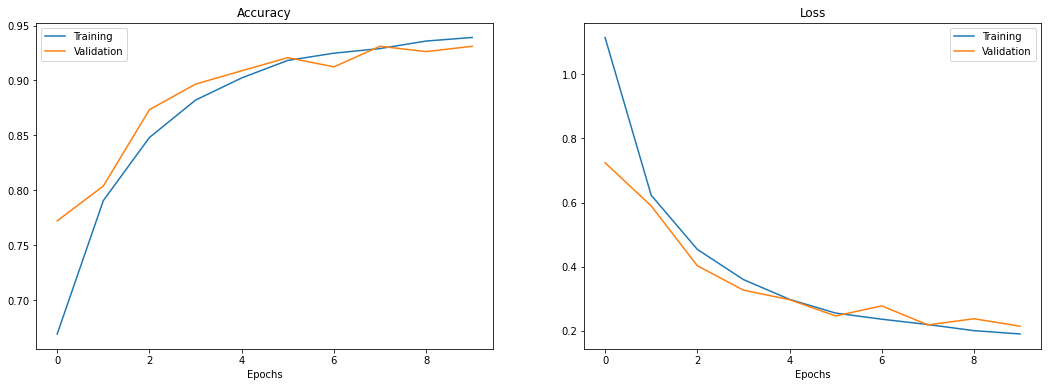

In [35]:
# 2 subplots
_, (r, l) = plt.subplots(1, 2, figsize=(18,6))

# Accuracy Graph
r.plot(history.history["categorical_accuracy"])
r.plot(history.history["val_categorical_accuracy"])
r.set_xlabel("Epochs")
r.set_title("Accuracy")
r.legend(["Training", "Validation"])

# Loss Graph
l.plot(history.history["loss"])
l.plot(history.history["val_loss"])
l.set_xlabel("Epochs")
l.set_title("Loss")
l.legend(["Training", "Validation"])

plt.savefig(f"results/{msu}_graph.png")
plt.show()

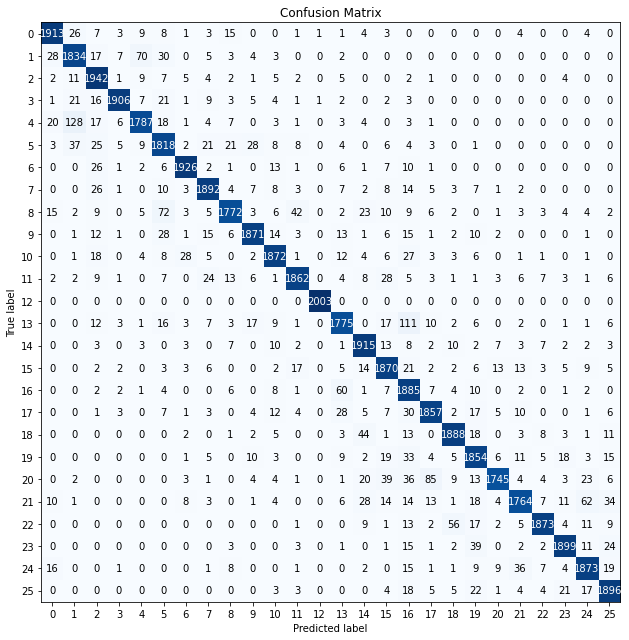

In [36]:
# based on https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html as sklearn 0.22's requires a classifier

# Get the classifications assigned by the model
predictions = np.argmax(model.predict(testing), axis=-1)

# Reformat labels for CM usage
_tstLabels = np.asarray([list(a).index(1) for a in tstLabels])

# Compute confusion matrix
cm = confusion_matrix(_tstLabels, predictions)

# Report on total and categorical accuracy
summ = open(f"results/{msu}_model.txt","w+")
model.summary(print_fn=lambda l: summ.write(f"{l}\n"))
summ.write("\n")
summ.write(f"Training time (total): {(end-start):.1f}s\n")
summ.write(f"Training time (avg): {(end-start)/EPOCHS:.1f}s\n")
summ.write(f"Accuracy (total-{spec}): {sum([cm[i][i] / len(tstLabels) for i in range(26)]):.2%}\n")
summ.write(f"Per category: {', '.join([f'{cm[i][i]*26 / len(tstLabels):.0%}' for i in range(26)])}\n")
summ.close()

# Only plot assigned labels
classes = unique_labels(_tstLabels, predictions)

# Single plot
fig, ax = plt.subplots(figsize=(9,9))
im = ax.imshow(cm, cmap=plt.cm.Blues)
# ax.figure.colorbar(im, ax=ax)

# Grid
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title="Confusion Matrix",
       ylabel="True label", xlabel="Predicted label")

# Annotate with confusion matrix, background scaled, text colour kept in contrast
threshold = cm.max() / 2.
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(j, i, format(cm[i, j], "d"),
            ha="center", va="center",
            color="white" if cm[i, j] > threshold else "black")
fig.tight_layout()
plt.savefig(f"results/{msu}_matrix.png")
plt.show()

In [37]:
DO_CLEANUP_OLD_RESULTS = "no" #@param ["yes", "no"]
DO_CLEANUP_OLD_ARCHIVE = "yes" #@param ["yes", "no"]
DO_DOWNLOAD_RESULTS = "yes" #@param ["yes","no"]
if DO_CLEANUP_OLD_RESULTS=="yes":
  for f in Path("./results/").glob("*"):
    if not f.is_dir(): f.unlink()
  for f in Path("./results/").glob("*"):
    f.rmdir()
if DO_CLEANUP_OLD_ARCHIVE=="yes":
  for f in Path().glob("results-*.zip"):
    f.unlink()
if DO_DOWNLOAD_RESULTS=="yes":
  with ZipFile(f"results-{datetime.now():%Y-%m-%d-%H-%M-%S}.zip", mode="w", compression=ZIP_DEFLATED) as z:
    for f in Path("./results/").rglob("*"):
      z.write(f)
  try:
    from google.colab import files
    for f in Path().glob("*results-*.zip"):
      files.download(f)
  except (ModuleNotFoundError, AttributeError) as e:
    print("Download/Export only matters for Colab, normal .ipynb is local")
  except Exception as e:
    raise e

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>